# CSE527 Homework 4
**Due date: 23:59 on April 24, 2021 (Sat.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 120 points including 20 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import gc
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/My Drive/JAIN_MAYANK_113263864_hw4'

/content/gdrive/My Drive/JAIN_MAYANK_113263864_hw4


In [5]:
!pip install git+https://github.com/ncullen93/torchsample

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-a3jkbiv4
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-a3jkbiv4
  Created wheel for torchsample: filename=torchsample-0.1.3-cp37-none-any.whl size=43416 sha256=461813705c1472191e46b09a95a41fffe99b35d6669e113a9daed2cb73581cfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-mr213mvn/wheels/88/c7/72/14cd9a173eed1e29d0b17d866e7d9ee511d31a834aedd27489
Successfully built torchsample


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [6]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation 
    n = len(data)
    if augment:
      for i in range(0, n):
        data.append(cv2.flip(data[i], -1))
        data.append(cv2.flip(data[i], 0))
        labels.append(labels[i])
        labels.append(labels[i])

    ##########-------END OF CODE-------##########    
    
    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization

    if zero_centered:
      for i in range(0, n):
        data[i] = data[i] - np.mean(data[i])
        
    ##########-------END OF CODE-------##########
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Highway', 1: 'Office', 2: 'Bedroom', 3: 'Forest', 4: 'TallBuilding', 5: 'Street', 6: 'Coast', 7: 'InsideCity', 8: 'Suburb', 9: 'Mountain', 10: 'Flower', 11: 'LivingRoom', 12: 'Kitchen', 13: 'Industrial', 14: 'Store', 15: 'OpenCountry'} 


In [7]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cla

OpenCountry


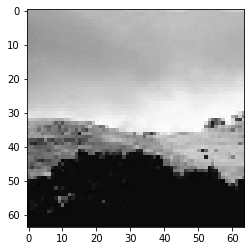

In [8]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [9]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
  

Then, let's define model training and evaluation functions.

In [10]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [11]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  

Finally, let's start training and evaluation.

In [12]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:10 | Train Loss: 2.7420 | Average Loss: 2.7420 
Epoch: 1 | Iter:   20 | Time: 00:00:10 | Train Loss: 2.4636 | Average Loss: 2.6597 
Accuracy: 0.364583 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.8821 | Average Loss: 2.4587 
Epoch: 2 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.9113 | Average Loss: 2.2366 
Accuracy: 0.393229 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.4826 | Average Loss: 2.1133 
Epoch: 3 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.5420 | Average Loss: 1.9692 
Accuracy: 0.437500 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.1937 | Average Loss: 1.8746 
Epoch: 4 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.2330 | Average Loss: 1.7650 
Accuracy: 0.455729 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:11 | Train Loss: 0.9677 | Average Loss: 1.6870 
Epoch: 5 | Iter:   20 | Time: 00:00:11 | Train Loss: 0.9879 | Average Loss: 1.5982 
Accuracy: 0.4661

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1
(35 points) Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you **left-right flip (mirror) an image** of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't **zero-centered**. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add **dropout layer**. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer (and try others if that helps). Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The minimum accuracy required for this section is **0.55**.

In [13]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 112 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cl

In [15]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class Improved_TNet(nn.Module):
  def __init__(self):
    super(Improved_TNet,self).__init__()
    self.features = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Conv2d(32, 256, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5)
    )
    self.classifier = nn.Sequential(
        nn.Linear(2304, 16),
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [16]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = Improved_TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7730 | Average Loss: 2.7730 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6935 | Average Loss: 2.7699 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5303 | Average Loss: 2.6929 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.2288 | Average Loss: 2.5832 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 2.1758 | Average Loss: 2.4965 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.0131 | Average Loss: 2.4187 
Accuracy: 0.346354 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.8708 | Average Loss: 2.3750 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.8322 | Average Loss: 2.3060 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.9132 | Average Loss: 2.2449 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.6714 | Average Loss: 2.1962 
Epoch: 2 | Iter:   80 | Time: 00:00:01 | Train Loss: 1.8677 | Average Loss: 2.1530 
Epoch: 2 | Iter:  100 | Time: 00:00:01 |

**Answer**:

Data augmentation: Inputs flipped horizontally and vertically

Data normalization: Normalized with mean centered to zero

Layer 1: Convolutional layer-> input = 1, output = 32, size of kernel = 3

Layer 2: Rectified layer unit

Layer 3: maxpool having stride and size equal to 4

Layer 4: Convolutional layer-> input = 32, output = 256, size of kernel = 3

Layer 5: Rectified layer unit

Layer 6: maxpool having stride and size equal to 4

Layer 7: Dropout having 0.5 probability

Layer 8: Linear classifier -> input = 2304, output channels = 16



Accuray on test set:  0.632812


## Problem 1.2

(15 points) Try **three different techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)

### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 112 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cl

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class ModelArchitectureModification(nn.Module):
  def __init__(self):
    super(ModelArchitectureModification,self).__init__()
    self.features = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5),
        nn.Conv2d(64, 400, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5)
    )

    self.classifier = nn.Sequential(
        nn.Linear(3600, 16),
    )
    
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x



In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------

net = ModelArchitectureModification()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8524 | Average Loss: 2.8524 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6371 | Average Loss: 2.8358 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.6224 | Average Loss: 2.7287 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.4428 | Average Loss: 2.6403 
Epoch: 1 | Iter:   80 | Time: 00:00:01 | Train Loss: 2.3099 | Average Loss: 2.5725 
Epoch: 1 | Iter:  100 | Time: 00:00:01 | Train Loss: 2.2317 | Average Loss: 2.5038 
Accuracy: 0.278646 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.0972 | Average Loss: 2.4684 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.9971 | Average Loss: 2.4122 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.1556 | Average Loss: 2.3658 
Epoch: 2 | Iter:   60 | Time: 00:00:02 | Train Loss: 1.9035 | Average Loss: 2.3235 
Epoch: 2 | Iter:   80 | Time: 00:00:02 | Train Loss: 1.6953 | Average Loss: 2.2770 
Epoch: 2 | Iter:  100 | Time: 00:00:02 |

**Answer**:

Technique 1: Model Architecture Modification with changes in convolutional layer.

Accuracy on test set: 0.651042

Accuracy increases/decreases: Increases

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

img_size = (64, 64)
batch_size = 64 

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 112 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cl

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class BatchNormalization(nn.Module):
  def __init__(self):
    super(BatchNormalization,self).__init__()
    self.features = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5),
        nn.Conv2d(32, 256, 3),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5)
    )

    self.classifier = nn.Sequential(
        nn.Linear(2304, 16),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x



In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = BatchNormalization()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.5077 | Average Loss: 3.5077 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 3.7669 | Average Loss: 5.3302 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5844 | Average Loss: 4.2669 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.4953 | Average Loss: 3.7337 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 2.6907 | Average Loss: 3.4305 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.3662 | Average Loss: 3.2286 
Accuracy: 0.302083 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.0547 | Average Loss: 3.1353 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.0829 | Average Loss: 3.0188 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.1225 | Average Loss: 2.9091 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.4064 | Average Loss: 2.8201 
Epoch: 2 | Iter:   80 | Time: 00:00:01 | Train Loss: 2.3330 | Average Loss: 2.7429 
Epoch: 2 | Iter:  100 | Time: 00:00:01 |

**Answer**:

Technique 2: Batch Normalization technique

Accuracy on test set: 0.645833

Accuracy increases/decreases: increases

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
import torchvision.transforms as transforms
import torchsample as ts

train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0], [1])
    ])

test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0], [1])
    ])
# Train data augmented
augmentedTrainData = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./data/train/', transform=train),
batch_size=64, shuffle=True)

# Test data augmented
augmentedTestData = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./data/test/', transform=test),
batch_size=64, shuffle=True)

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class AugmentationTechnique(nn.Module):
  def __init__(self):
    super(AugmentationTechnique,self).__init__()
    self.features = torch.nn.Sequential(
      nn.Conv2d(1, 32, 3),
      nn.ReLU(),
      nn.MaxPool2d(4, stride=4),
      nn.Dropout(0.5),
      nn.Conv2d(32, 256, 3),
      nn.ReLU(),
      nn.MaxPool2d(4, stride=4),
      nn.Dropout(0.5)
    )

    self.classifier = nn.Sequential(
      nn.Linear(2304, 16),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = AugmentationTechnique()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 300
train_option['device'] = 'gpu'
trainModel(net, augmentedTrainData, train_option, augmentedTestData)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8014 | Average Loss: 2.8014 
Epoch: 1 | Iter:   20 | Time: 00:00:03 | Train Loss: 2.7598 | Average Loss: 2.8361 
Accuracy: 0.112500 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:08 | Train Loss: 2.6692 | Average Loss: 2.7877 
Epoch: 2 | Iter:   20 | Time: 00:00:11 | Train Loss: 2.6756 | Average Loss: 2.7414 
Accuracy: 0.217500 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:00:16 | Train Loss: 2.5598 | Average Loss: 2.7013 
Epoch: 3 | Iter:   20 | Time: 00:00:19 | Train Loss: 2.4890 | Average Loss: 2.6622 
Accuracy: 0.255000 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:00:23 | Train Loss: 2.2978 | Average Loss: 2.6293 
Epoch: 4 | Iter:   20 | Time: 00:00:27 | Train Loss: 2.4188 | Average Loss: 2.5922 
Accuracy: 0.242500 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:00:31 | Train Loss: 2.1192 | Average Loss: 2.5622 
Epoch: 5 | Iter:   20 | Time: 00:00:35 | Train Loss: 2.2164 | Average Loss: 2.5288 
Accuracy: 0.2900

**Answer**:

Technique 3: Data augmention technique using torchvision

Accuracy on test set: 0.635000 (epoch 290)

Accuracy increases/decreases: increases

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(25 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))



Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cla

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

#Finetuning pretrained alexnet model
finetune_alexnet = models.alexnet(pretrained=True)
finetune_alexnet.classifier[6] = nn.Linear(4096,16)

train_option = {}
train_option['lr'] = 0.00015
train_option['epoch'] = 15
train_option['device'] = 'gpu'
trainModel(finetune_alexnet, trainloader_large, train_option, testloader_large)
gc.collect()

Epoch: 1 | Iter:    0 | Time: 00:00:03 | Train Loss: 3.0622 | Average Loss: 3.0622 
Epoch: 1 | Iter:   20 | Time: 00:00:05 | Train Loss: 0.6512 | Average Loss: 1.3405 
Accuracy: 0.848958 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.4349 | Average Loss: 0.9789 
Epoch: 2 | Iter:   20 | Time: 00:00:09 | Train Loss: 0.3109 | Average Loss: 0.7902 
Accuracy: 0.825521 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:11 | Train Loss: 0.2197 | Average Loss: 0.6731 
Epoch: 3 | Iter:   20 | Time: 00:00:13 | Train Loss: 0.1816 | Average Loss: 0.5761 
Accuracy: 0.843750 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:15 | Train Loss: 0.0827 | Average Loss: 0.5113 
Epoch: 4 | Iter:   20 | Time: 00:00:17 | Train Loss: 0.1247 | Average Loss: 0.4556 
Accuracy: 0.861979 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:19 | Train Loss: 0.1105 | Average Loss: 0.4150 
Epoch: 5 | Iter:   20 | Time: 00:00:21 | Train Loss: 0.0490 | Average Loss: 0.3786 
Accuracy: 0.8645

2441

**Answer**:

(1) which layers of AlexNet have been replaced - Layer number 6


(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation: Inputs flipped horizontally and vertically

Data normalization: Normalized with zero mean

Features Layers : No changes done

Classifier Layer 1: No changes done

Classifier Layer 2: No changes done

Classifier Layer 3: No changes done

Classifier Layer 4: No changes done

Classifier Layer 5: No changes done

Classifier Layer 6: Changes done to make count of output featues equal to count of class in the given data.


(3) the final accuracy on test set

Accuracy on test set: 0.856771 at epoch 15



### Problem 2.2
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(25 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on test set. You should be able to achieve accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------

def getFeatures(model, features_count, dataset):

  if torch.cuda.is_available():
    model = model.cuda()
        
  features = []
  labels = []
    
  for img, label in dataset:
    if torch.cuda.is_available():
      img  = img.float().cuda()
      label = label.long().cuda()
        
    img_out = model(img)
    
    for index2, img_it in enumerate(img_out):
      features.append(np.array(img_it[:features_count].cpu().detach().numpy()))
      labels.append(label[index2].cpu().detach().numpy())
            
  return np.array(features), np.array(labels)
    

train_feat, train_label = getFeatures(finetune_alexnet, 400, trainloader_large)
test_feat, test_label = getFeatures(finetune_alexnet, 400, testloader_large)

In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn import svm
from sklearn import preprocessing

#Calculating accuracy using techniques used in assignment 3

def train_SVM(X, Y):
  return svm.SVC(C=0.95).fit(X, Y)

def predict_SVM(clf, X):
  return clf.predict(X)


clf = train_SVM(train_feat, train_label)
test_label_pred = predict_SVM(clf, test_feat)

accuracy = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
print("The accuracy is {:.2f}%".format(accuracy*100))

The accuracy is 87.50%


**Answer**:

Accuracy on test set: 87.50 PERCENT

### Problem 2.3 (Bonus)

(Bonus: 10 points) Bonus will be given to those who fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. Explain why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------


#Fine Tune resnet 50
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(2048, 16)

train_option = {'optimizer':optim.RMSprop(resnet_model.parameters(), lr=0.0001)}
train_option['lr'] = 0.0001
train_option['epoch'] = 10
train_option['device'] = 'gpu'
trainModel(resnet_model, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8197 | Average Loss: 2.8197 
Epoch: 1 | Iter:   20 | Time: 00:00:14 | Train Loss: 0.4744 | Average Loss: 0.9583 
Accuracy: 0.921875 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:28 | Train Loss: 0.2645 | Average Loss: 0.6909 
Epoch: 2 | Iter:   20 | Time: 00:00:43 | Train Loss: 0.0509 | Average Loss: 0.4916 
Accuracy: 0.934896 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:00:56 | Train Loss: 0.0272 | Average Loss: 0.3977 
Epoch: 3 | Iter:   20 | Time: 00:01:11 | Train Loss: 0.0115 | Average Loss: 0.3185 
Accuracy: 0.945312 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:01:24 | Train Loss: 0.0088 | Average Loss: 0.2720 
Epoch: 4 | Iter:   20 | Time: 00:01:38 | Train Loss: 0.0036 | Average Loss: 0.2316 
Accuracy: 0.945312 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:01:51 | Train Loss: 0.0052 | Average Loss: 0.2058 
Epoch: 5 | Iter:   20 | Time: 00:02:06 | Train Loss: 0.0023 | Average Loss: 0.1818 
Accuracy: 0.9453

**Answer**:

Accuracy on test set: 0.945312

ResNet performed better because enhancing residual mapping is simpler than unreferenced mapping. Also, in the ResNet accuracy increases with depth while for AlexNet more training error is observed. The convergence rate for ResNet is also fast as compared to others.


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_hw4.zip" for homework4 in this structure:
```
LeCun_Yann_111134567_hw4
        |---LeCun_Yann_111134567_hw4.ipynb
        |---LeCun_Yann_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
